# Forcasting with LSTM on NGA time serie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
path_1 = '../Data/test_st.csv'
path_2 = '../Data/extaction_missing_data.csv'
path_saved_models = "../saved_models/model_nga_1h_2.keras"

In [3]:
df = pd.read_csv(path_1)
df.index = pd.to_datetime(df['value_created_at'])
df

,value_created_at,measure_id,point_id,NGA,NGV,K,VCC_g,VC_g
value_created_at,,,,,,,,
2023-06-24 15:05:48,2023-06-24 15:05:48,12870679,232710,0.10832,2.77359,1.891347,0.49635,0.41004
2023-06-24 15:22:51,2023-06-24 15:22:51,12870678,232710,0.10783,3.13995,1.896530,0.48180,0.42522
2023-06-24 15:50:00,2023-06-24 15:50:00,12870677,232710,0.10815,2.66659,1.887733,0.48101,0.40710
2023-06-24 15:55:00,2023-06-24 15:55:00,12870676,232710,0.10708,2.65100,1.901864,0.48632,0.40771
2023-06-24 16:00:00,2023-06-24 16:00:00,12870675,232710,0.10750,2.55173,1.898690,0.49191,0.42289
...,...,...,...,...,...,...,...,...
2024-03-01 06:40:00,2024-03-01 06:40:00,21130040,232710,0.54927,4.42352,4.068230,9.18245,4.87565
2024-03-01 07:40:00,2024-03-01 07:40:00,21132241,232710,0.52915,4.16160,4.259252,8.98788,5.14323
2024-03-01 08:40:00,2024-03-01 08:40:00,21134403,232710,0.55540,4.46625,4.059374,8.60813,4.33526


In [4]:
nga = df['NGA']

In [5]:
def df_to_X_y(df, window_size=5, delay=1):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size-delay+1):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size+delay-1]
    y.append(label)
  return np.array(X), np.array(y)

In [6]:
WINDOW_SIZE = 382
DELAY = 1
X, y = df_to_X_y(nga, WINDOW_SIZE, DELAY)
X.shape, y.shape

((5322, 382, 1), (5322,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1915, 382, 1), (1915,), (479, 382, 1), (479,), (2928, 382, 1), (2928,))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MAE
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(28,
           dropout=0.06297029003850252,
           recurrent_dropout=0.5818137908766273))
model1.add(Dense(55, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 28)                  │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 55)                  │           1,595 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              56 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,011 (19.57 KB)

 Trainable params: 5,011 (19.57 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cp1 = ModelCheckpoint(path_saved_models, save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.007009812507590492))

In [10]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 255ms/step - loss: 0.9571 - val_loss: 0.0598
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - loss: 0.1217 - val_loss: 0.1206
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.2477 - val_loss: 0.1547
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - loss: 0.2513 - val_loss: 0.0704
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 234ms/step - loss: 0.1355 - val_loss: 0.3999
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - loss: 0.1463 - val_loss: 0.1224
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step - loss: 0.2115 - val_loss: 0.0685
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1140 - val_loss: 0.0621
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - loss: 0.3144 - val_loss: 0.0557
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.1935 - val_loss: 0.1883


In [11]:
from tensorflow.keras.models import load_model
model1 = load_model(path_saved_models)

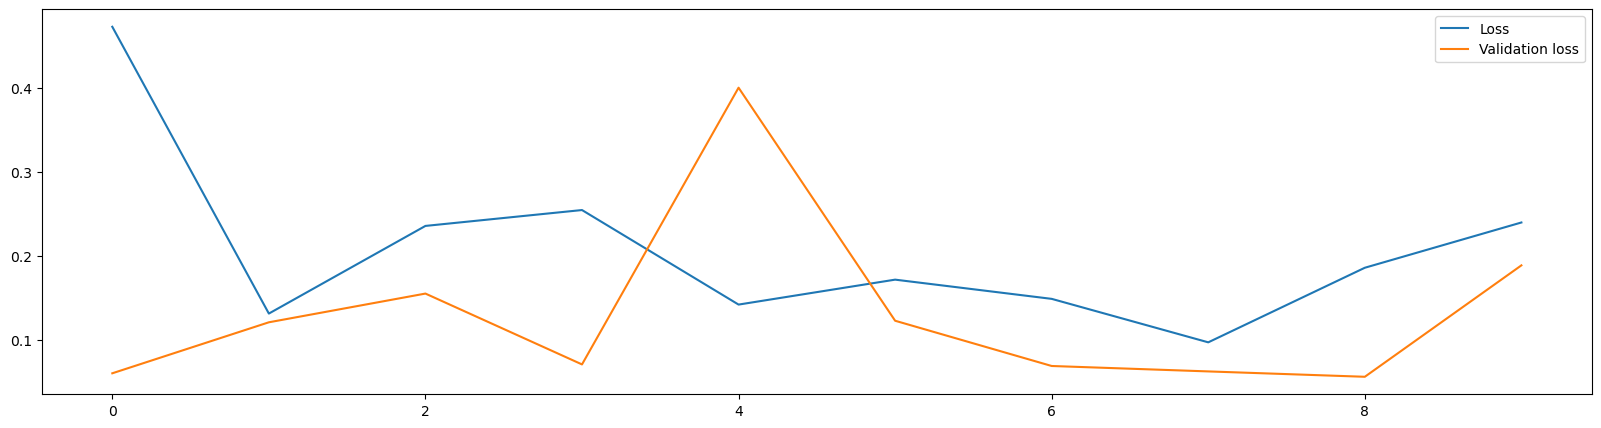

In [12]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [13]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step


,Train Predictions,Actuals
0,0.448641,0.49800
1,0.452564,0.49498
2,0.454555,0.47803
3,0.451491,0.48509
4,0.451195,0.50724
...,...,...
1910,8.204054,8.13306
1911,8.210772,7.83652
1912,8.093320,7.70279
1913,7.999975,7.63318


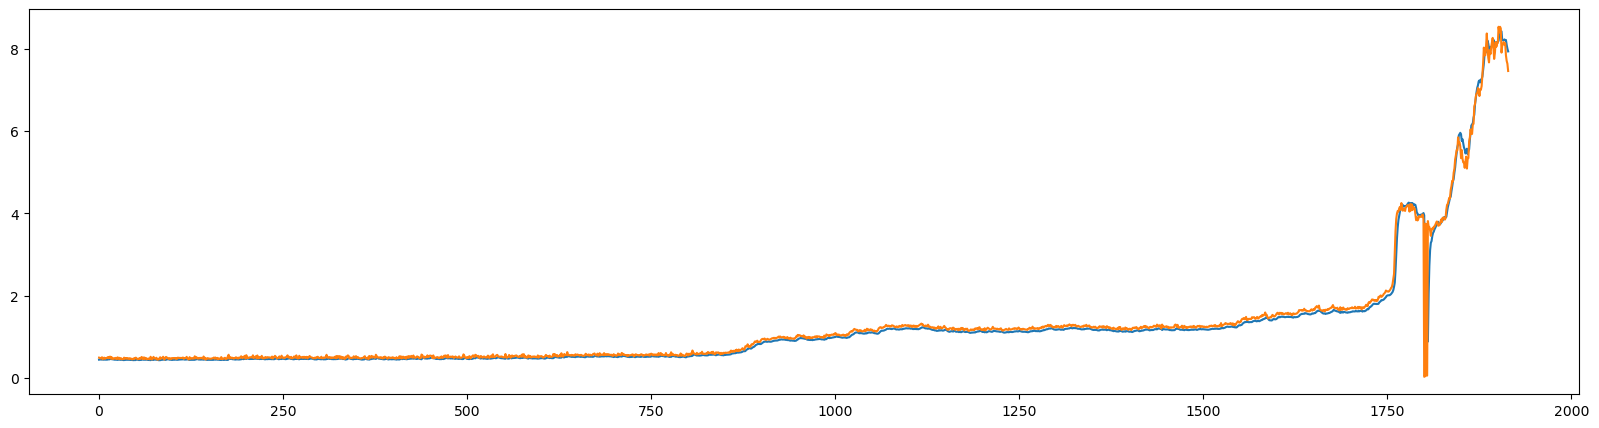

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [15]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


,Val Predictions,Actuals
0,7.825488,7.73697
1,7.900486,7.51359
2,7.819805,7.48536
3,7.780087,7.48393
4,7.760113,7.30606
...,...,...
474,3.407529,3.25765
475,3.326103,3.80201
476,3.571679,3.28693
477,3.412051,3.59670


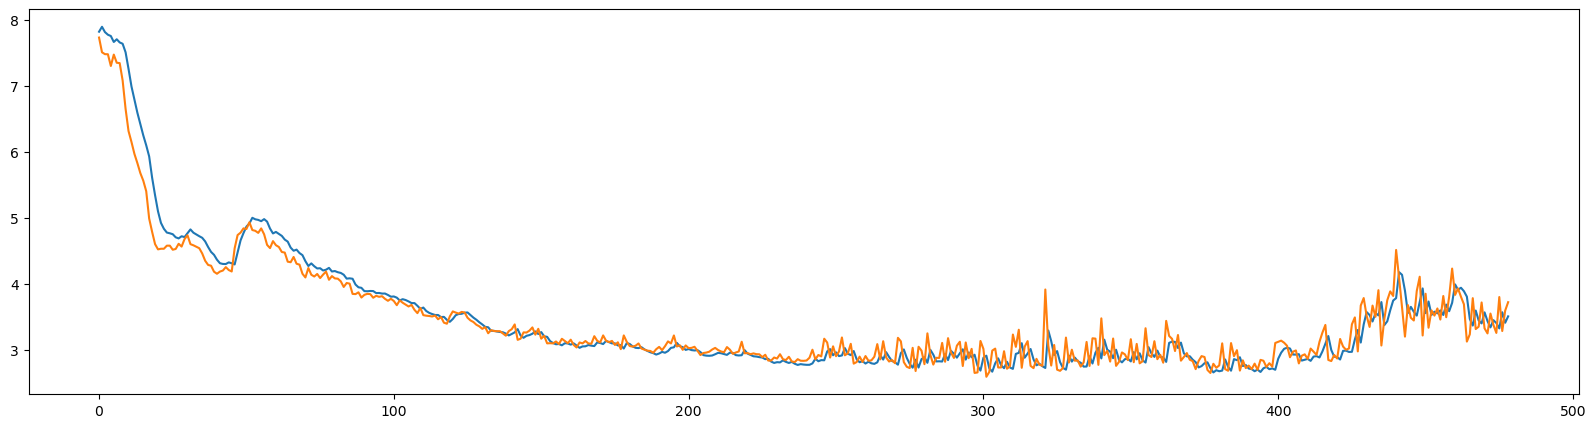

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [17]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step


,Test Predictions,Actuals
0,3.618214,3.50452
1,3.555475,3.48110
2,3.519822,3.52392
3,3.525308,4.18767
4,3.876306,3.44115
...,...,...
2923,0.540087,0.54927
2924,0.528916,0.52915
2925,0.514915,0.55540
2926,0.514253,0.50074


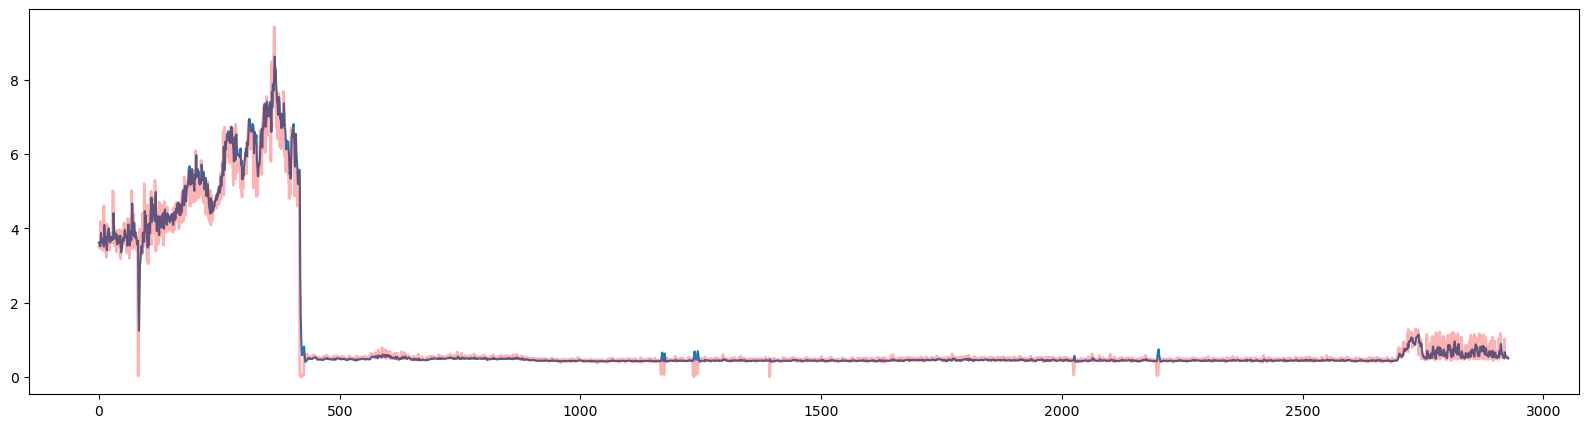

In [18]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'], linewidth=2, alpha=0.3, color='red')

In [19]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
print("Test RMSE : ", root_mean_squared_error(y_test, test_predictions))
print("Test MAE : ", mean_absolute_error(y_test, test_predictions))

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (C:\Users\user\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\__init__.py)